## Алгоритм компенсации

Обозначим список ключевых изменяющихся параметров (напрямую влияющие на фактический вылив):

1. Ограничения насосов (мин/макс скорость, и их параметры ускорения/остановки)
2. Норма внесения
3. Максимально допустимая скорость дрона

Обозначим порядок в котором будем менять параметры:
1. Скорость дрона
2. Норма внесения


Возьмём в качестве критического значения вызывающего пересчёт с компенсацией:

`max_available_error_litters = 1`

Также не маловажно определить политику важности направления ошибки (есть ли разница, и что важнее - перелить или недолить):
на текущий момент будем считать это равным


### Итак, разберём следующие варианты:

1. Запрещается переливать (допускается недолив):
    - Насосы будут отключаться в случаях когда требуется работать на меньшей скорости чем они могут.

2. Запрет на недолив (допускается перелив):
    - Насосы будут переливать (работать на своем минимуме, даже когда требуется меньшая скорость)
    - Максимальная скорость дрона будет снижена


In [1]:
from policy import PolicyFactory, ViolationMode

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
from use_cases import PumpFacade, PumpingPolicy
from parse_log import Plan
from pathlib import Path

req_norma = 1000 # Л/Га
drone_v_max = 2.0  # максимально допустимая скорость дрона (м/с)

pump_min_speed = 2  # л/мин
pump_max_speed = 13  # л/мин

tank_volume = 40  # л

log_file_path = Path(
    r"C:\Users\nodax\Downloads\Telegram Desktop\spraying_20250908_080420_485_24a89b48_9ecb_4956_bdb3_4d01f9de0f4a.json")

plan = Plan.get_plan_from_log_file(log_file_path)


self.volume_total=989.4243750253751, self.total_dispensed_by_pump_plan=166.41123704321774
Попробуйте уменьшить максимальную скорость дрона
count    7647.000000
mean        0.109181
std         0.017845
min         0.000000
25%         0.108333
50%         0.108333
75%         0.108333
max         0.645528
dtype: float64
diff = -0.5363467644947989
СКО = 0.2879862474871499


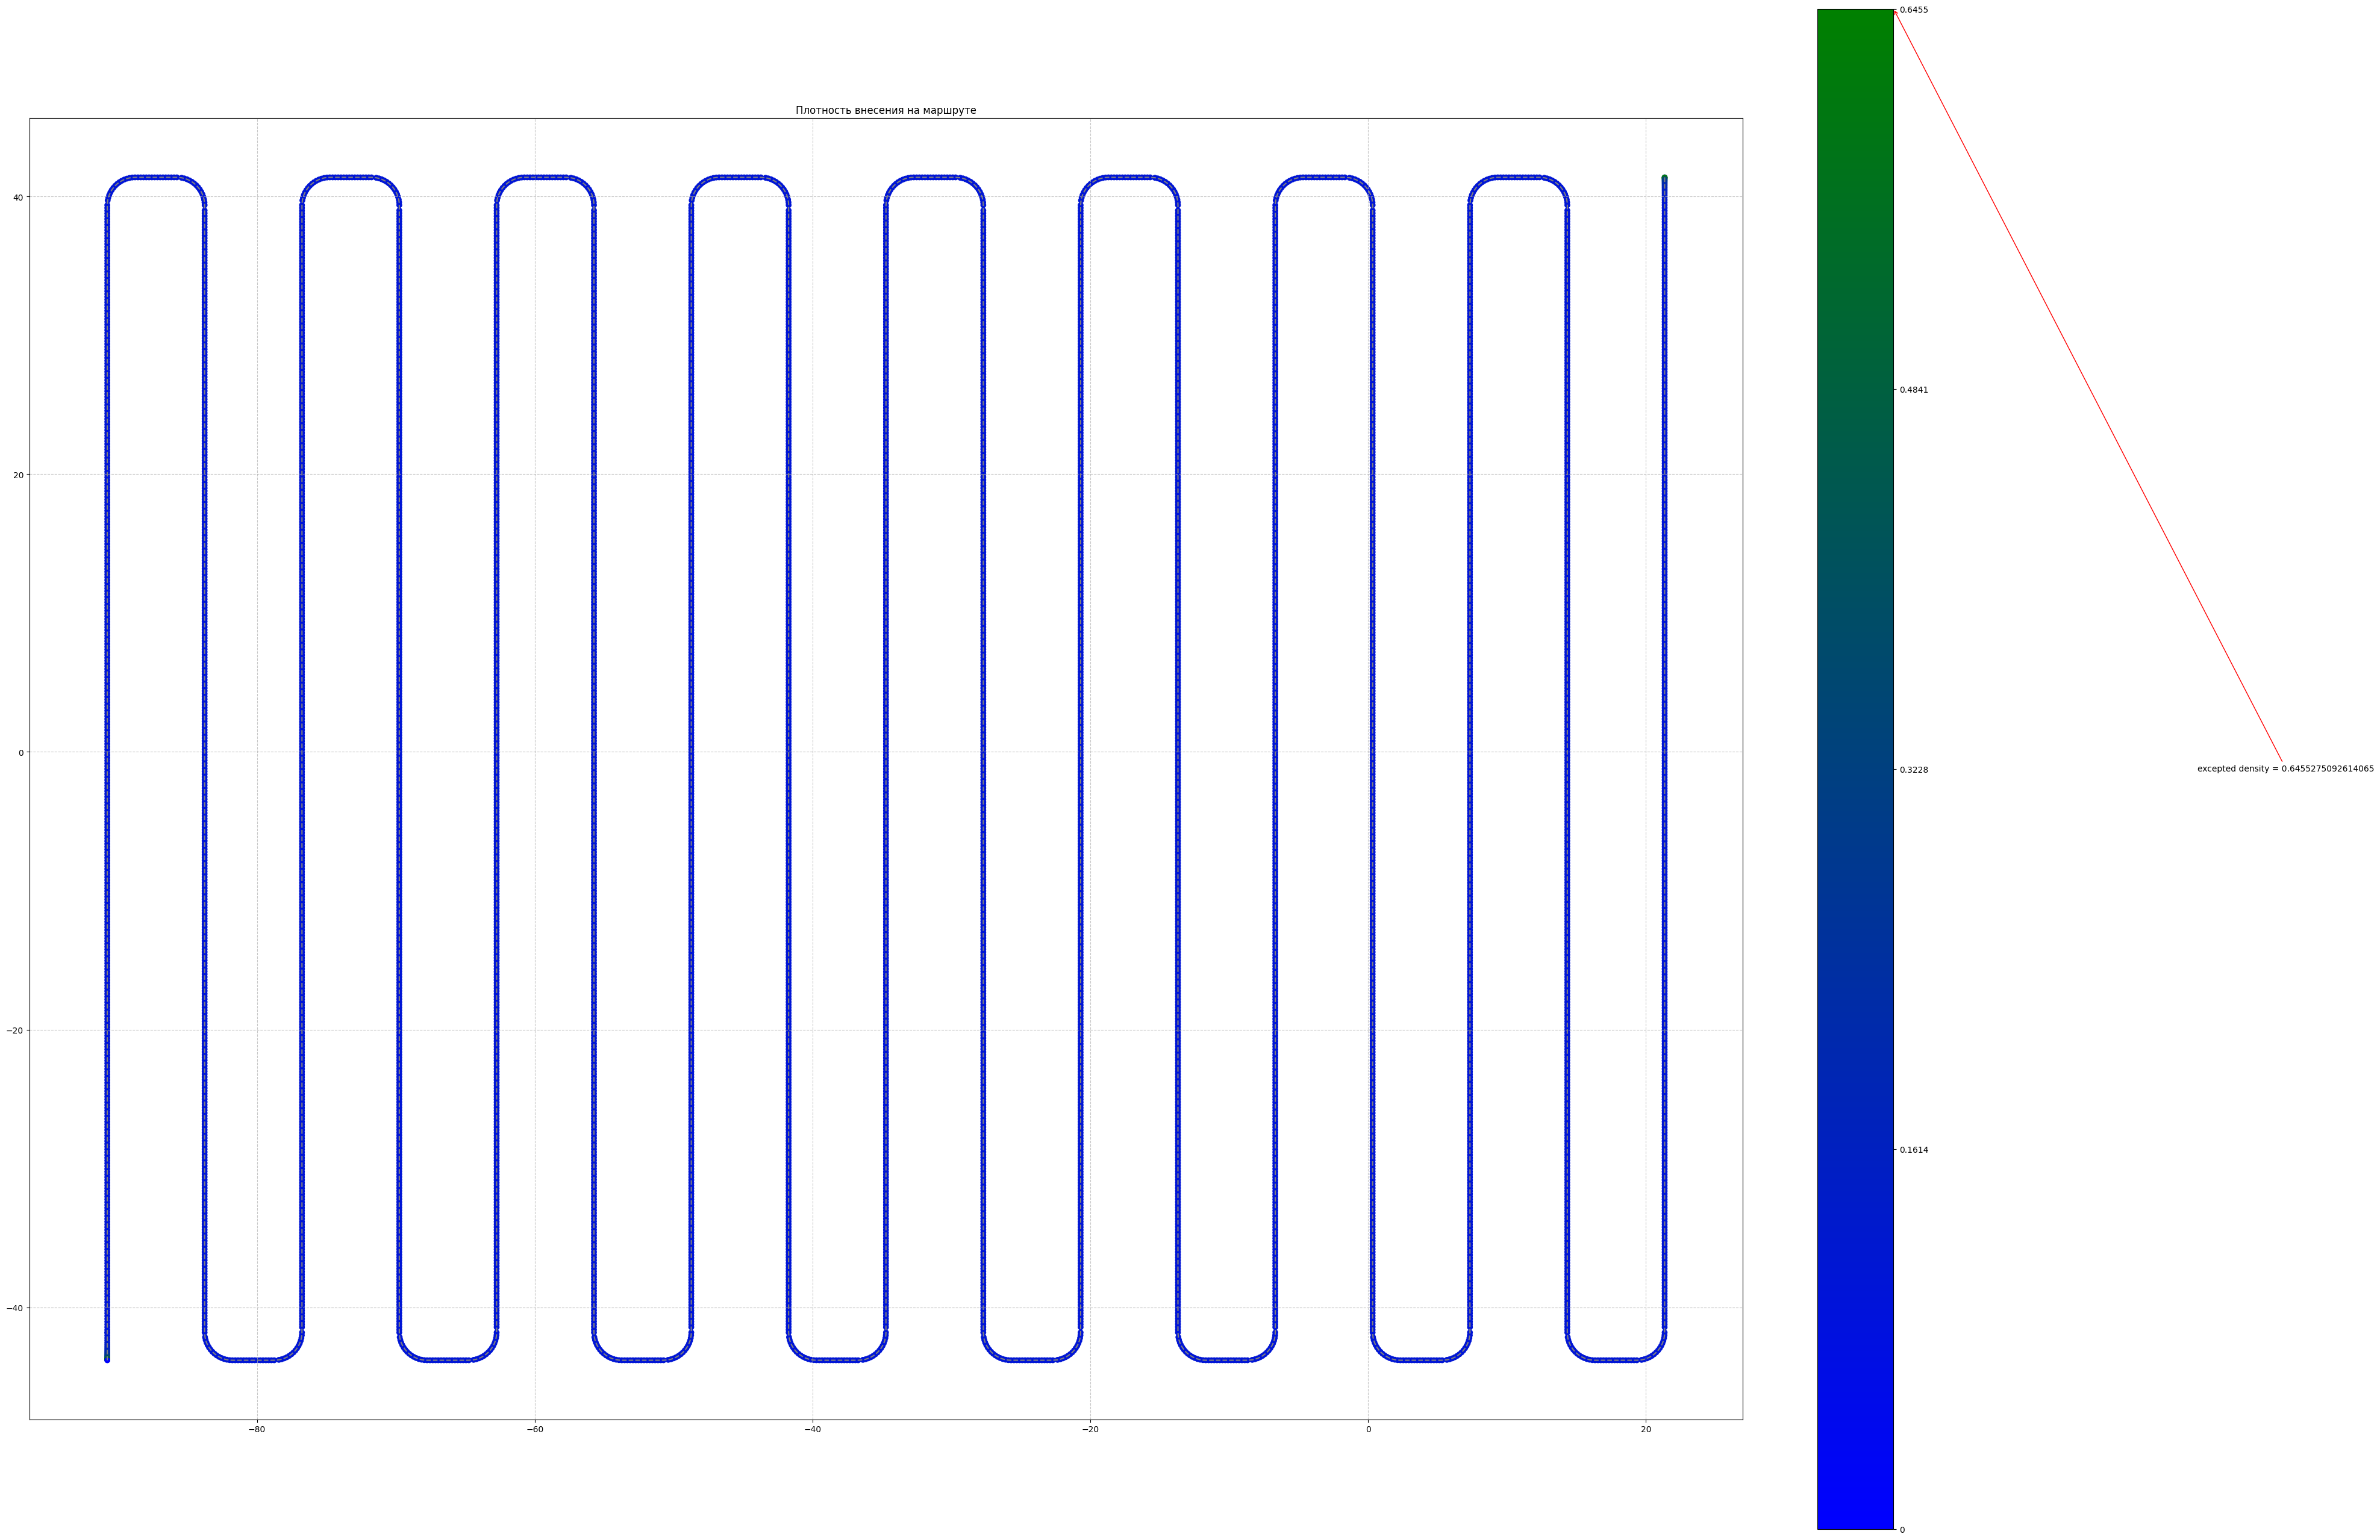

In [40]:
pf = PumpFacade.from_simple_params(plan=plan,
                                   norma=req_norma,
                                   max_drone_speed=drone_v_max,
                                   pump_min_speed=pump_min_speed,
                                   pump_max_speed=pump_max_speed,
                                   tank_volume=tank_volume,
                                   pumping_policy=PumpingPolicy.NoUnderfillPolicy)

pf.plot()


In [5]:
pf.profile.total_distance

1532.7377390274896

In [6]:
pf.profile.total_duration

540.6707009116814

In [7]:
pf.density

0.006455275092614065

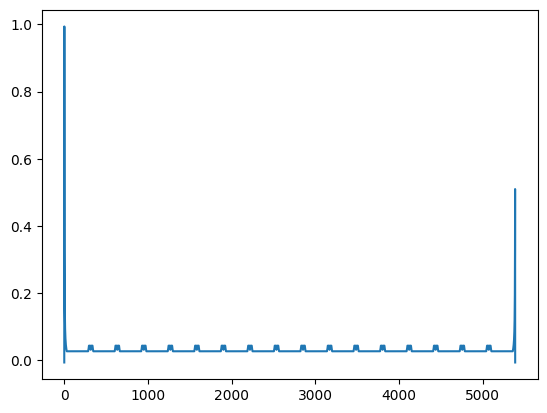

In [8]:
plt.plot(pf.diff_density)

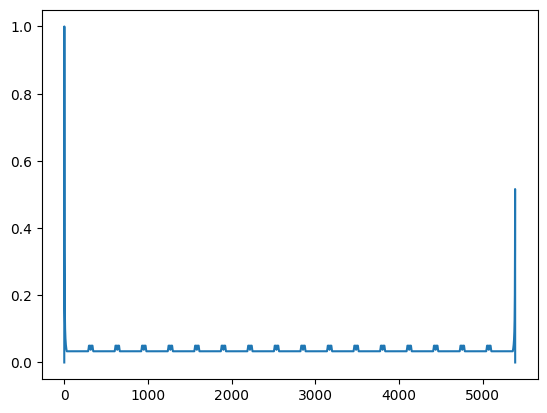

In [9]:
plt.plot(pf.instant_introduction_density)

In [10]:
diff = pf.instant_introduction_density

# ещё

In [11]:
# pf = PumpFacade.from_simple_params(plan=plan,
#                                    norma=req_norma,
#                                    max_drone_speed=drone_v_max,
#                                    pump_min_speed=pump_min_speed,
#                                    pump_max_speed=pump_max_speed,
#                                    tank_volume=tank_volume,
#                                    pumping_policy=PumpingPolicy.NoOverflowPolicy)
#
# pf.plot()
# d = pf.density

In [12]:
# policy = PolicyFactory.with_tolerance(over_tol=0.5,  # Допускаем переливать 0,5 л
#                                       under_tol=0.5,  # Допускаем не доливать 0,5 л
#                                       w_over=2,  # Переливание в 2 раза хуже
#                                       violation=ViolationMode.IGNORE  # Кидаем исключения при нарушениях
#                                       )
#
# target = 0
# x = np.linspace(-10, 10, 21) / 10
# y = [policy.cost(target, i) for i in x]
# plt.plot(x, y)